# model

> Basic architecture and components of mamba

In [102]:
#| default_exp model

### Mamba Implementation in JAX Equinox

Suggest reading the following before/while reading the code:
* [1] Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Albert Gu and Tri Dao)
    https://arxiv.org/abs/2312.00752
* [2] The Annotated S4 (Sasha Rush and Sidd Karamcheti)
    https://srush.github.io/annotated-s4
* Inspired by https://github.com/johnma2006/mamba-minimal

Glossary:
* b: batch size                       (`B` in Mamba paper [1] Algorithm 2)
* l: sequence length                  (`L` in [1] Algorithm 2)
* d or d_model: hidden dim
* n or d_state: latent state dim      (`N` in [1] Algorithm 2)
* expand: expansion factor            (`E` in [1] Section 3.4)
* d_in or d_inner: d * expand         (`D` in [1] Algorithm 2)
* A, B, C, D: state space parameters  (See any state space representation formula)
                                    (B, C are input-dependent (aka selective, a key innovation in Mamba); A, D are not)
* Δ or delta: input-dependent step size
* dt_rank: rank of Δ                  (See [1] Section 3.6 "Parameterization of ∆")


In [103]:
#| hide
from nbdev.showdoc import *

In [104]:
#| export
import numpy as np
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jla
import equinox as eqx

from miniMamba.modelArgs import ModelArgs

In [105]:
#| hide
rng = jax.random.PRNGKey(0)

### State space models

State space models(SSMs) give a mapping from a $1-D$ input $u(t)$ onto an $N-D$ latent state $x(t)$, which is then projected down a $1-D$ output $y(t)$.

$$
\begin{aligned}
x'(t) &= Ax(t)+ Bu(t) \\
y(t) &= Cx(t) + Du(t)
\end{aligned}
$$
where $A,B,C,$ and $D$ are learnable parameters. 

For simplicity lets start by omitting the $D$ term. $Du$ can be viewed as an easy to compute skip connection

In [106]:
#| export
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

To apply this SSM on a discrete sequence $(u_0,u_1,u_2,\dots)$ instead of the continous function $u(t)$, it must be discretized with step size $\Delta$ representing input resolution so that input $u_k:=u(k\Delta)$

This discretization can be performed by a bilinear transformation, mapping the state matrix $A$ to $\bar{A}$.
$$
\begin{aligned}
\bar{A} &= (I-\Delta/2 A)^{-1}(I+\Delta/2 A) \\
\bar{B} &= (I-\Delta/2 A)^{-1}\Delta B \\
\bar{C} &= C
\end{aligned}
$$

In [107]:
def discretize(A, B, C, step):
    I = jnp.eye(A.shape[0])
    BL = jla.inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

Given this sequence to sequence mapping, the discrete SSM can be computed like n RNN with a recurrence relation in $x$.
$$
\begin{aligned}
x_{k} &= \bar{A}x_{k-1} + \bar{B}u_k \\
y_k &= \bar{C}x_k
\end{aligned}
$$

In [108]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

To run the SSM we first discretize and then iterate.

In [109]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

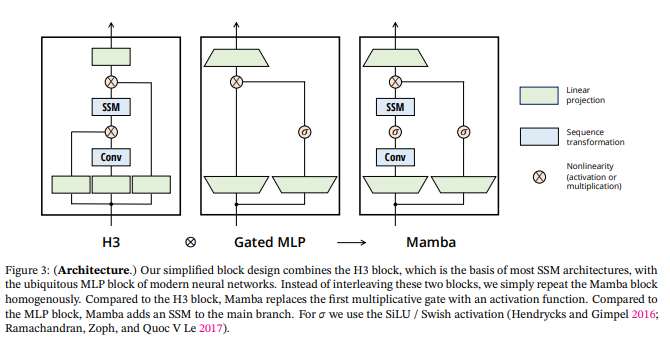|

Model from Figure 3 of 2312.00752

In [110]:
class MambaBlock(eqx.Module):
    args: ModelArgs
    in_proj: eqx.nn.Linear
    conv1d: eqx.nn.Conv
    x_proj: eqx.nn.Linear
    dt_proj: eqx.nn.Linear
    out_proj: eqx.nn.Linear
    log_A: jnp.ndarray
    D: jnp.ndarray
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.args = args

        self.in_proj = eqx.nn.Linear(args.d_model, args.d_inner*2, use_bias=args.bias, key = rng)

        self.conv1d = eqx.nn.Conv1D(in_channels=args.d_inner, 
                                 out_channels=args.d_inner, 
                                 kernel_size=args.d_conv,
                                 groups=args.d_inner,
                                 use_bias= args.conv_bias,
                                 key = rng)
        # maps x to (Δ, B, C)
        self.x_proj = eqx.nn.Linear(args.d_inner, args.dt_rank+args.d_state*2, use_bias=False, key = rng)

        # projects Δ from dt_rank to d_in
        self.dt_proj = eqx.nn.Linear(args.dt_rank, args.dt_inner, use_bias=True, key = rng)
        
        self.out_proj = eqx.nn.Linear(args.d_inner, args.d_model, use_bias=args.bias, key = rng)

        A = jnp.tile(jnp.arange(1, args.d_state + 1), (args.inner, 1))
        self.log_A = jnp.log(A)
        self.D = jnp.ones((args.d_inner, args.d_inner))

    def forward(self, x):
        """
        Mamba forward pass, looks like figure 3
        (seq_len, d_model) -> (seq_len, d_model)
        """
        (L,d) = x.shape

        x_and_res = self.in_proj(x) # (L, d_inner*2)
        (x, res) = jnp.split(x_and_res, 2, axis=-1) # (L, d_inner)
        x = self.conv1d(x.T)[:,:,:, :L].T # (L, d_inner)
        x = jax.nn.silu(x)

        y = self.ssm(x)
        y *= jax.nn.silu(res)
        
        output = self.out_proj(y)

        return output
    
    def ssm(self, x):
        """
        Run SSM
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        
        A = -jnp.exp(self.A_log) # (d_in, n)
        D = self.D

        x_dbl = self.x_proj(x) # (l, d_rank+ d_state*2)
        (delta, B, C) = jnp.split(x_dbl, [self.args.dt_rank, self.args.d_state,
                                          self.args.d_state], axis=-1) # (1, d_rank), (l, d_state), (l, d_state)
        delta = jax.nn.softplus(self.dt_proj(delta)) # (l, d_inner)

        y = self.selective_scan(x, delta, A, B, C, D)

        return y

    def selective_scan(self, u, delta, A, B, C, D):
        """ 
        Discretize and Selective scan
        """
        (L, d_in) = u.shape
        n = A.shape[1]

        # Discretizing continouis parameters acc eq 4
        deltaA = jnp.exp(jnp.einsum('ld, dn -> ldn', delta, A))
        deltaB_u = jnp.einsum('ld,ln, ld->ldn', delta, B * u)

        # perform selective scan
        y = scan_SSM(deltaA, deltaB_u, C, u, jnp.zeros((n,)))

        y += u*D
    
    def scan_SSM(Ab, Bb, Cb, u, x0):
        def step(x_k_1, u_k):
            x_k = Ab @ x_k_1 + Bb @ u_k
            y_k = Cb @ x_k
            return x_k, y_k

        return jax.lax.scan(step, x0, u)



In [111]:
class RMSnorm(eqx.Module):
    eps: float
    weight: jnp.ndarray
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = jnp.ones((d_model,))

    def __call__(self, x):
        output = x * jax.lax.rsqrt(jnp.mean(x**2, axis=-1, keepdims=True) + self.eps) * self.weight
        return output

In [112]:
rng = jax.random.PRNGKey(0)
d_model = 10  # Choose an appropriate size for the test

# Create a random input tensor
x = jax.random.normal(rng, (5, d_model))

# Instantiate the RMSnorm module
rmsnorm_module = RMSnorm(d_model)

In [113]:
rmsnorm_module(x)

Array([[-0.28202367, -1.7751259 , -1.3276266 ,  0.21005142,  0.00262558,
        -1.0843129 , -1.1610469 ,  0.17709939, -0.2544334 ,  1.5305542 ],
       [-0.24652143, -0.7815071 ,  0.41000503,  0.53822225, -1.3681791 ,
        -2.1942427 , -0.27373582,  1.3746103 ,  0.3120011 ,  0.34948558],
       [-0.34938094,  0.26039216,  1.1528395 , -0.28252405, -1.6644143 ,
         1.4754516 , -0.5000238 ,  0.12314829, -1.2202971 , -1.3036996 ],
       [ 0.81434023,  0.6395449 ,  0.05811654, -0.08327827,  0.42880297,
         0.22944313, -0.07316481,  1.6281995 ,  2.4002602 ,  0.5130036 ],
       [-1.188451  , -0.14157107,  0.9150801 ,  1.1505973 , -1.235271  ,
        -0.4042365 , -1.7946148 , -0.13045768, -1.1099608 , -0.49715152]],      dtype=float32)

In [114]:
class ResidualBlock(eqx.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSnorm(args.d_model)

    def forward(self, x):
        self.mixer(self.norm(x)) + x

In [115]:
class Mamba(eqx.Module):
    def __init__(self, args: ModelArgs):
        pass

    def forward(self, x):
        pass

    @staticmethod
    def load_pretrained(pretrained_model_name: str):
        pass

In [116]:
#| hide
import nbdev; nbdev.nbdev_export()